In [1]:
import pandas as pd
import numpy as np
import glob
import os

from scipy.stats import norm, sem
from scipy.optimize import curve_fit
import scipy.signal
import scipy.signal.windows  
scipy.signal.gaussian = scipy.signal.windows.gaussian
import pymc as pm
import arviz as az
from metadpy.utils import trials2counts
from metadpy.mle import fit_metad, metad
from collections import Counter
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

In [88]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None)

In [89]:
csv_dir = "data/"
csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))

In [90]:
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

In [91]:
df['soa_offset'] = round((df['soa_ms'] - df['threshold']) / 7)

In [92]:
usable_subjects = ["Alex", "Kevin_F", "Brenna", "Caleb", "Sevan"]
df = df[df['subj'].isin(usable_subjects)]
df['confidence'] = np.where(df['confidence'] <= 2, 1, 2)

In [93]:
df.head()

,subj,trial,soa_ms,catch_trial,detect_yn,confidence,threshold,soa_offset
0,Alex,0,69.575979,False,False,1,49.0,3.0
1,Alex,1,55.660783,False,True,2,49.0,1.0
2,Alex,2,55.660783,False,True,2,49.0,1.0
3,Alex,3,34.787990,False,False,1,49.0,-2.0
4,Alex,4,76.533577,False,True,2,49.0,4.0


In [107]:
df[(df['subj'] == "Sevan") & (df['soa_offset'] == 4)]

,subj,trial,soa_ms,catch_trial,detect_yn,confidence,threshold,soa_offset,signal,resp,correct
2286,Sevan,0,62.261333,False,True,2,35.0,4.0,1,1,1
2304,Sevan,18,62.261333,False,True,2,35.0,4.0,1,1,1
2313,Sevan,27,62.261333,False,True,2,35.0,4.0,1,1,1
2317,Sevan,31,62.261333,False,True,2,35.0,4.0,1,1,1
2319,Sevan,33,62.261333,False,True,2,35.0,4.0,1,1,1
2335,Sevan,49,62.261333,True,False,1,35.0,4.0,0,0,1
2364,Sevan,78,62.261333,False,True,2,35.0,4.0,1,1,1
2374,Sevan,88,62.261333,False,True,2,35.0,4.0,1,1,1
2391,Sevan,105,62.261333,False,True,1,35.0,4.0,1,1,1
2405,Sevan,119,62.261333,True,False,1,35.0,4.0,0,0,1


## Calculate d' and meta-d' Scores

In [94]:
df["signal"]  = (~df["catch_trial"]).astype(int)
df["resp"]    = df["detect_yn"].astype(int)
df["correct"] = (df["resp"] == df["signal"]).astype(int)

rows = []
for (subj, soa), grp in df.groupby(["subj","soa_offset"]):
    # -------- d′ ----------
    H  = grp.query("signal==1 & resp==1").shape[0]
    FA = grp.query("signal==0 & resp==1").shape[0]
    n_sig   = grp.query("signal==1").shape[0]
    n_noise = grp.query("signal==0").shape[0]
    dprime  = norm.ppf((H+0.5)/(n_sig+1)) - norm.ppf((FA+0.5)/(n_noise+1))

    # -------- meta-d′ ----------
    try:
        # Pass the group DataFrame directly
        meta = metad(data=grp,  # Pass the DataFrame for the current group
                    stimuli="signal",
                    accuracy="correct",
                    confidence="confidence",
                    nRatings=2,
                    padding=True,  # Let metadpy handle padding
                    verbose=0
                    )
        meta_d = float(meta.loc[0, "meta_d"])
    except Exception as e:
        meta_d = np.nan

    rows.append(dict(subj=subj, soa_offset=soa,
                     dprime=dprime, meta_dprime=meta_d))

summary = pd.DataFrame(rows)

In [95]:
summary['m_ratio'] = summary['meta_dprime'] / summary['dprime']

In [105]:
summary[summary['subj'] == "Sevan"]

,subj,soa_offset,dprime,meta_dprime,m_ratio
36,Sevan,-4.0,-0.607958,0.513822,-0.845159
37,Sevan,-3.0,-0.607958,0.513822,-0.845159
38,Sevan,-2.0,-0.607958,0.513822,-0.845159
39,Sevan,-1.0,-0.070151,NaN,NaN
40,Sevan,-0.0,1.429539,NaN,NaN
41,Sevan,1.0,1.580858,-0.238494,-0.150864
42,Sevan,2.0,1.580858,0.502595,0.317925
43,Sevan,3.0,2.102344,0.328053,0.156042
44,Sevan,4.0,3.171062,-0.533335,-0.168188


## Summarize Statistics

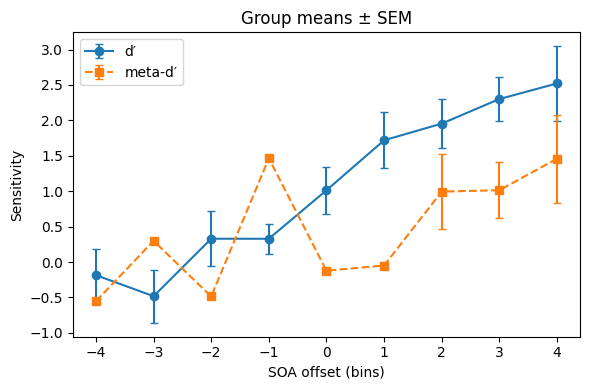

In [97]:
# 2) Group‐level means and SEM by SOA
grouped = summary.groupby('soa_offset').agg(
    mean_d   = ('dprime',      'mean'),
    sem_d    = ('dprime',      sem),
    mean_m   = ('meta_dprime', 'mean'),
    sem_m    = ('meta_dprime', sem)
).reset_index()

# 3) Plot group means with error bars
plt.figure(figsize=(6,4))
plt.errorbar(grouped['soa_offset'],
             grouped['mean_d'],
             yerr=grouped['sem_d'],
             fmt='o-', label="d′", capsize=3)
plt.errorbar(grouped['soa_offset'],
             grouped['mean_m'],
             yerr=grouped['sem_m'],
             fmt='s--', label="meta-d′", capsize=3)
plt.xlabel("SOA offset (bins)")
plt.ylabel("Sensitivity")
plt.title("Group means ± SEM")
plt.legend()
plt.tight_layout()
plt.show()

## Fit Logistic Psychometric Functions

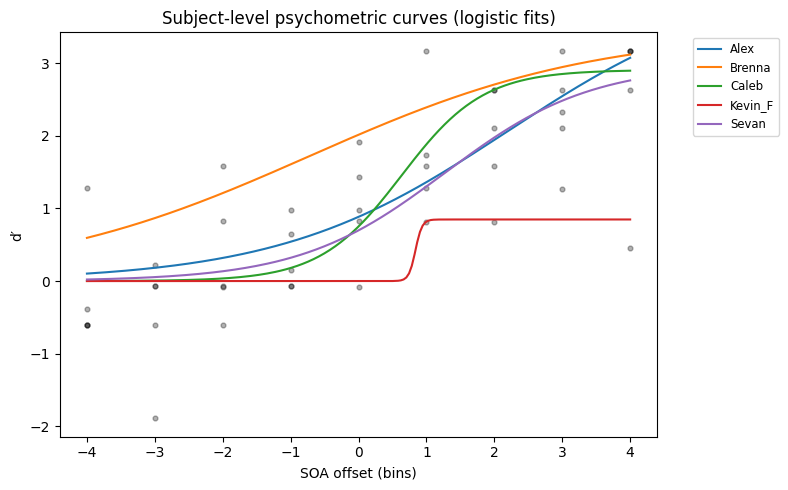

In [98]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k*(x - x0)))

params_d = {}
soa_min, soa_max = summary['soa_offset'].min(), summary['soa_offset'].max()
x_dense = np.linspace(soa_min, soa_max, 200)

plt.figure(figsize=(8,5))
for subj, grp in summary.groupby('subj'):
    x = grp['soa_offset'].values
    y = grp['dprime'].values
    # initial guesses: [asymptote, slope, midpoint]
    p0 = [np.nanmax(y), 1.0, np.median(x)]
    try:
        popt, _ = curve_fit(logistic, x, y, p0=p0, maxfev=5000)
    except:
        popt = [np.nan, np.nan, np.nan]
    params_d[subj] = popt
    plt.plot(x_dense, logistic(x_dense, *popt), label=subj)

plt.scatter(summary['soa_offset'], summary['dprime'],
            color='k', s=12, alpha=0.3)
plt.xlabel("SOA offset (bins)")
plt.ylabel("d′")
plt.title("Subject-level psychometric curves (logistic fits)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_91564\562862140.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)


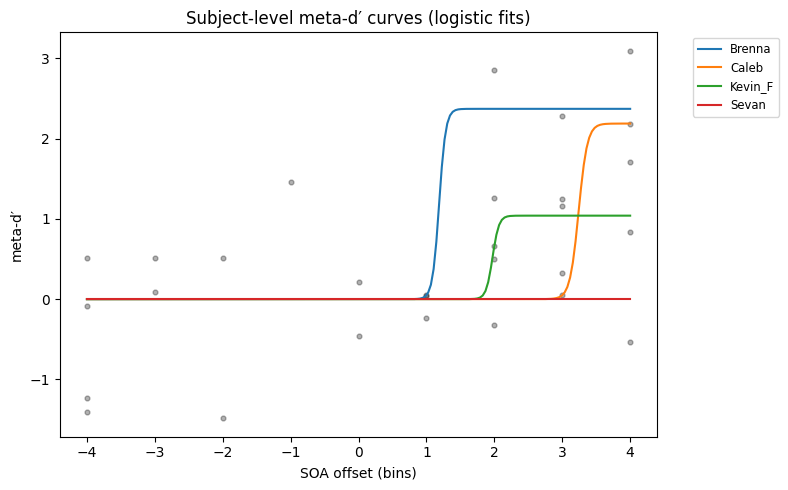

In [99]:
params_m = {}
plt.figure(figsize=(8,5))
for subj, grp in summary.groupby('subj'):
    x = grp['soa_offset'].values
    y = grp['meta_dprime'].values
    mask = ~np.isnan(y)
    if mask.sum() < 4:
        params_m[subj] = [np.nan, np.nan, np.nan]
        continue
    p0 = [np.nanmax(y[mask]), 1.0, np.median(x[mask])]
    try:
        popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)
    except:
        popt = [np.nan, np.nan, np.nan]
    params_m[subj] = popt
    plt.plot(x_dense, logistic(x_dense, *popt), label=subj)

plt.scatter(summary['soa_offset'], summary['meta_dprime'],
            color='k', s=12, alpha=0.3)
plt.xlabel("SOA offset (bins)")
plt.ylabel("meta-d′")
plt.title("Subject-level meta-d′ curves (logistic fits)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_91564\3636306900.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)


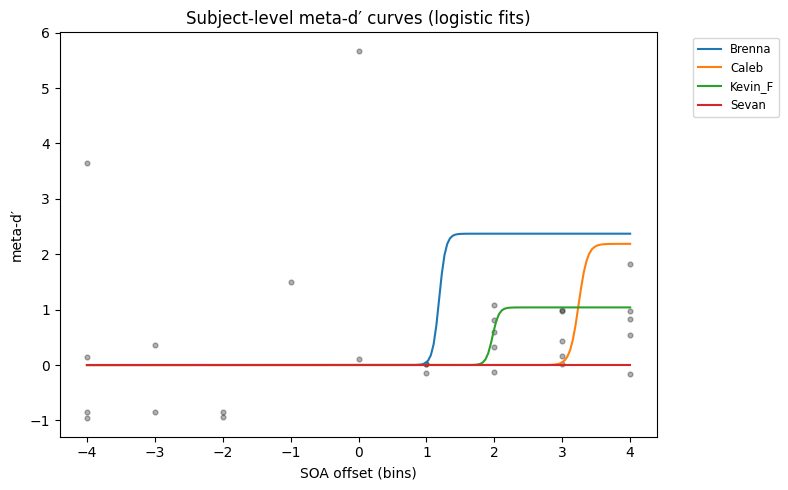

In [104]:
params_m = {}
plt.figure(figsize=(8,5))
for subj, grp in summary.groupby('subj'):
    x = grp['soa_offset'].values
    y = grp['meta_dprime'].values
    mask = ~np.isnan(y)
    if mask.sum() < 4:
        params_m[subj] = [np.nan, np.nan, np.nan]
        continue
    p0 = [np.nanmax(y[mask]), 1.0, np.median(x[mask])]
    try:
        popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)
    except:
        popt = [np.nan, np.nan, np.nan]
    params_m[subj] = popt
    plt.plot(x_dense, logistic(x_dense, *popt), label=subj)

plt.scatter(summary['soa_offset'], summary['m_ratio'],
            color='k', s=12, alpha=0.3)
plt.xlabel("SOA offset (bins)")
plt.ylabel("meta-d′")
plt.title("Subject-level meta-d′ curves (logistic fits)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

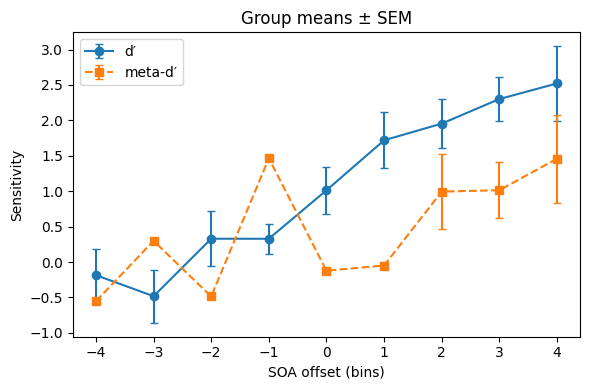

In [101]:
grp = summary.groupby('soa_offset').agg(
    mean_d = ('dprime',      'mean'),
    sem_d  = ('dprime',      sem),
    mean_m = ('meta_dprime', 'mean'),
    sem_m  = ('meta_dprime', sem)
).reset_index()

plt.figure(figsize=(6,4))
plt.errorbar(grp['soa_offset'], grp['mean_d'], yerr=grp['sem_d'],
             fmt='o-', capsize=3, label="d′")
plt.errorbar(grp['soa_offset'], grp['mean_m'], yerr=grp['sem_m'],
             fmt='s--', capsize=3, label="meta-d′")
plt.xlabel("SOA offset (bins)")
plt.ylabel("Sensitivity")
plt.title("Group means ± SEM")
plt.legend()
plt.tight_layout()
plt.show()


In [102]:
params_df = (
    pd.DataFrame.from_dict(params_d, orient='index', 
                           columns=['d_L','d_k','d_x0'])
      .join(pd.DataFrame.from_dict(params_m, orient='index',
               columns=['m_L','m_k','m_x0']))
      .reset_index()
      .rename(columns={'index':'subj'})
)
print(params_df.to_string(index=False))

   subj      d_L       d_k      d_x0      m_L       m_k      m_x0
   Alex 4.138041  0.590771  2.205576      NaN       NaN       NaN
 Brenna 3.446183  0.477256 -0.715694 2.371626 20.665767  1.186467
  Caleb 2.906710  1.662331  0.633437 2.188171 15.626417  3.241373
Kevin_F 0.848005 20.679001  0.838043 1.040532 21.361437  1.973251
  Sevan 2.979600  0.931266  1.271629 0.657637  6.762387 13.116662
